In [24]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk

(examples:cbed_quickstart)=
# CBED quickstart

In [2]:
abtem.config.set({"device": "gpu"})
abtem.config.set({"fft": "mkl"})

## Create atomic model

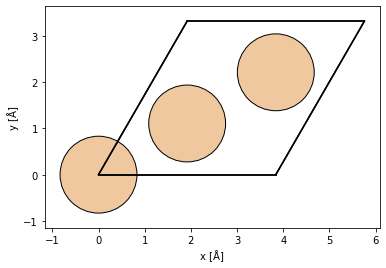

In [3]:
silicon = bulk("Si", crystalstructure="diamond")

silicon_111_hexagonal = ase.build.surface(silicon, (1, 1, 1), layers=3, periodic=True)

abtem.show_atoms(silicon_111_hexagonal, plane="xy");

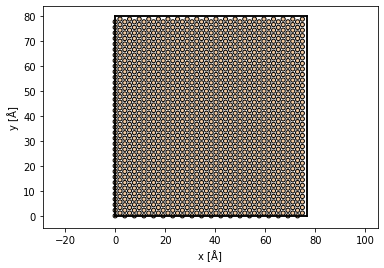

In [4]:
silicon_111 = abtem.orthogonalize_cell(silicon_111_hexagonal)

silicon_111 *= (20, 12, 100)

abtem.show_atoms(silicon_111);

## Potential with frozen phonons

In [ ]:
frozen_phonons = abtem.FrozenPhonons(silicon_111, 24, {"Si": 0.078})

In [14]:
potential = abtem.Potential(
    frozen_phonons,
    gpts=768,
    projection="infinite",
    slice_thickness=2,
    exit_planes=10,
)

In [15]:
potential.sampling

(0.09998931827716023, 0.10391194768213013)

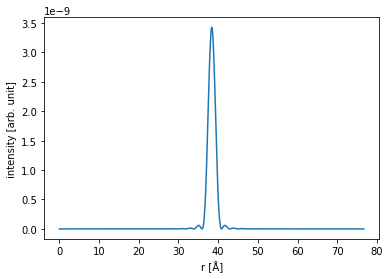

In [16]:
wave = abtem.Probe(energy=100e3, semiangle_cutoff=9.4, taper=0.5)
wave.grid.match(potential)

wave.profile().show();

In [17]:
measurement = wave.multislice(potential).diffraction_patterns(max_angle=30)

measurement.array

dask.array<_diffraction_pattern, shape=(24, 49, 127, 131), dtype=float32, chunksize=(1, 49, 127, 131), chunktype=cupy.ndarray>

In [18]:
measurement = measurement.mean(0)

measurement.array

dask.array<mean_agg-aggregate, shape=(49, 127, 131), dtype=float32, chunksize=(49, 127, 131), chunktype=cupy.ndarray>

In [19]:
measurement.compute()

[########################################] | 100% Completed | 54.32 ss


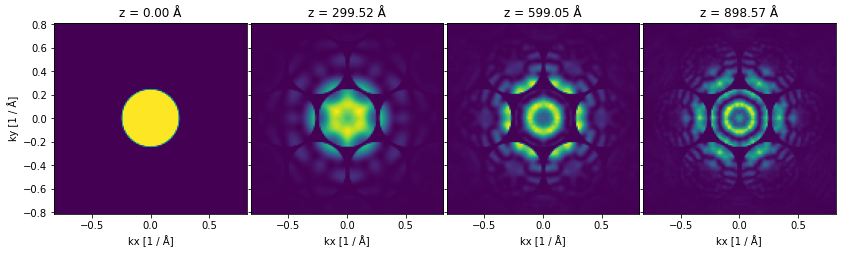

In [20]:
fig, ax = measurement[::15].show(
    explode=True,
    figsize=(14, 4),
    image_grid_kwargs={"axes_pad": 0.05},
)

In [1]:
fig, ax = measurement[-1].show()
ax.axis("off")
plt.savefig("../thumbnails/cbed_quickstart.png", bbox_inches="tight", pad_inches=0)

NameError: name 'measurement' is not defined